# Classifying Heart Disease in Patients using Multivariate 

## Introduction

#### Research question: Which physiological risk factors are most suitable for accurately classifying heart disease among patients?

Heart disease, also known as cardiovascular disease (CVD), is a major public health issue affecting millions of people worldwide. According to the World Health Organization (WHO), CVD is the leading cause of death globally, accounting for approximately 17.9 million deaths each year. It includes a range of conditions that affect the heart and blood vessels, including coronary artery disease, heart failure, and stroke.

The prevalence of heart disease is on the rise, with several risk factors contributing to its development. These risk factors include high blood pressure, high cholesterol, obesity, physical inactivity, and smoking. These risk factors are increasingly common in the population, making heart disease a significant public health challenge.

This dataset from the UCI Machine Learning Repository contains 14 attributes (which have been subsetted from 76 attributes originally) collected from 303 patients by medical center in Cleveland. Similar to the published studies on this dataset, our project will select a subset of attributes from the given 14 to help in the classification of heart disease in a patient. The attributes we will consider include age, rest_bp (resting blood pressure), cholestrol, max_hr (max heart rate), and st_depr (st depression). We will use these attributes to train the program to be able to predict the presence of heart disease in new patients. 

## Preliminary exploratory data analysis

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)
set.seed(100)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
## Loading the Data
heart_data_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_cols <- c("age", "sex", "chest_pain_type", "rest_bp", "cholesterol", "fast_blood_sugar", "rest_ecg", "max_hr", "ex_angina", "st_depr", "slope_peak", "major_vessel_num", "thal", "pres_val")
heart_data <- read_csv(heart_data_url, col_names = heart_cols) |>
    mutate(sex = as.factor(sex),
          chest_pain_type = as.factor(chest_pain_type),
          fast_blood_sugar = as.factor(fast_blood_sugar),
          rest_ecg = as.factor(rest_ecg),
          ex_angina = as.factor(ex_angina),
          slope_peak = as.factor(slope_peak),
          major_vessel_num = as.factor(major_vessel_num),
          thal = as.factor(as.integer(thal)),
          pres_val = as.factor(pres_val),
          presence = as.factor(ifelse(pres_val == 0, "no", "yes")))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): major_vessel_num, thal
dbl (12): age, sex, chest_pain_type, rest_bp, cholesterol, fast_blood_sugar,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in is.factor(x):
“NAs introduced by coercion”


age,sex,chest_pain_type,rest_bp,cholesterol,fast_blood_sugar,rest_ecg,max_hr,ex_angina,st_depr,slope_peak,major_vessel_num,thal,pres_val,presence
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6,0,no
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3,2,yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7,1,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7,3,yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3,1,yes
38,1,3,138,175,0,0,173,0,0.0,1,?,3,0,no


In [3]:
## Splitting the data into training/testing set
heart_split <- heart_data |>
    select(age, rest_bp, cholesterol, max_hr, st_depr, presence) |>
    initial_split(prop = 0.75, strata = presence)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [4]:
## Summarizing the training data (number of observations in each class)
heart_train_summary <- heart_train |>
    group_by(presence) |>
    summarize(count = n())
heart_train_summary

presence,count
<fct>,<int>
no,123
yes,104


In [5]:
## Summarizing the training data (means of each predictor variable)
heart_train_predictors_mean <- heart_train |>
    select(-presence) |>
    colMeans()
as.data.frame.list(heart_train_predictors_mean)

age,rest_bp,cholesterol,max_hr,st_depr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.43612,131.6256,248.7753,149.4758,1.028634


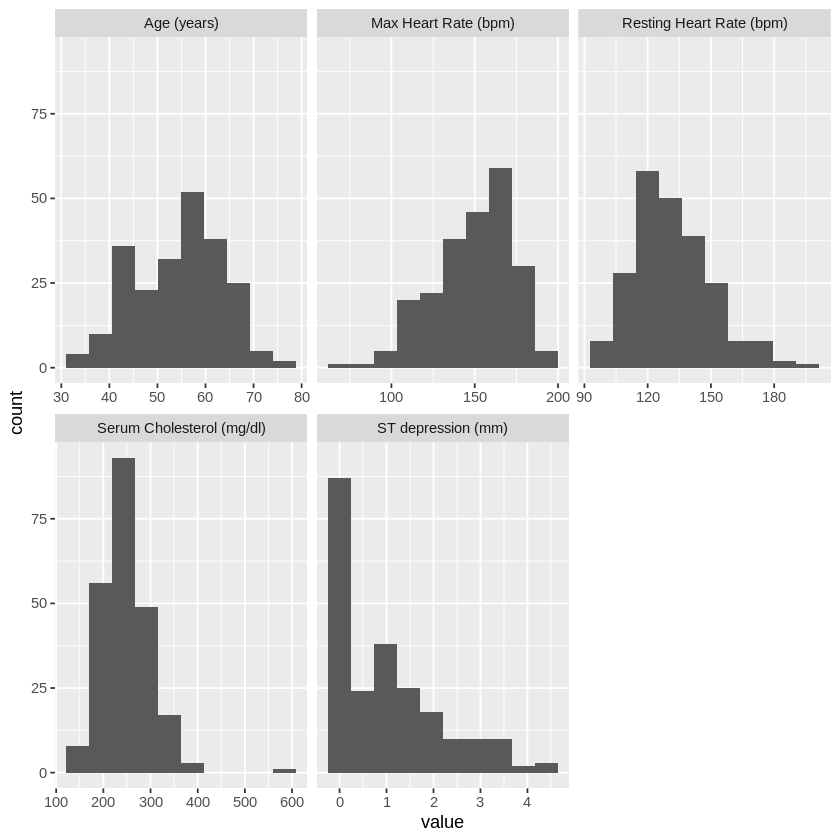

In [11]:
## Visualizing the training data (histogram distributions of each predictor column)
heart_train_long <- heart_train |>
    select(-presence) |>
    rename("Age (years)" = "age",
           "Serum Cholesterol (mg/dl)" = "cholesterol",
           "Max Heart Rate (bpm)" = "max_hr",
           "Resting Heart Rate (bpm)" = "rest_bp",
           "ST depression (mm)" = "st_depr") |>
    pivot_longer(cols = everything(), names_to = "predictor", values_to = "value")

heart_train_predictor_plot <- heart_train_long |>
    ggplot(aes(value)) + 
        geom_histogram(bins = 10) + 
        facet_wrap(~predictor, scales = 'free_x')
heart_train_predictor_plot

## Methods

For our data analysis, we will use tidymodel’s K-nearest neighbours to classify a new patient as either having heart disease or not (yes for heart disease present, no for no heart disease present).

We plan on following the main data analysis workflow steps when designing a K-nearest neighbours model to ensure efficiency and clarity. After tidying the data, filtering out the unneeded columns, and scaling and centering the data, we will split the data into a training set and a testing set and use the training set for cross validation. After analyzing the accuracies of various K values using a graph, we will choose the most reliable K value for our K-nearest neighbours model specification, recipe, and workflow.

The raw data contains thirteen columns that have the potential to act as predictors for the diagnosis of heart disease. In our data analysis, we will only use five of these: age, rest_bp (resting blood pressure), cholestrol, max_hr (max heart rate), and st_depr (st depression).

We will visualize the accuracy of each K value by creating a line plot depicting each K value and their respective accuracy. The plot of accuracy vs. number of neighbours will be used to choose the best K value. Additionally, we will visualize the final results by graphing all of the testing data on a scatter plot with each point coloured based on their predicted classification using our best classification model (one colour for yes, one for no).

## Expected outcomes and significance

Since heart disease can affect varying populations differently, we expect differences in the occurrence of heart disease among different age groups, genders, and collections of risk factors such as cholesterol and blood sugar in the development of the disease; furthermore, we expect that the greater one's age, resting blood pressure, serum cholesterol levels, maximum heart rate, and ST depression measurement, the greater the chance of that person being diagnosed with heart disease.

The findings of our project can be used to better understand the risk factors for heart disease by identifying populations that are most vulnerable to developing heart disease and recommending lifestyle changes to decrease the chances of developing heart disease, such as by developing better treatment plans suited for certain populations using personalized medicine. This project's findings can also be used for early screening, leading to healthcare professionals recognizing greater risk for heart disease and recommending patients take scanning tests to obtain more data for diagnosis.

Some of the future questions this project's findings could lead to include:

  1. Are there any methods to enhance heart disease diagnostic and screening procedures to ensure earlier recognition and treatment?
  2. How can healthcare professionals better inform the public about typical heart disease symptoms or warning signs to increase early detection?
  3. For certain age groups or genders at greater risk of heart disease, are there particular interventions or treatment modalities that are more successful?

## References

National Center for Chronic Disease Prevention and Health Promotion , Division for Heart Disease and Stroke Prevention. (2022, February 7). Heart Disease Facts. Retrieved March 10, 2022, from https://www.cdc.gov/heartdisease/facts.htm